# Train Sycophancy Detection Probes

**Goal:** Find a direction in activation space that separates "sycophantic" from "maintained" behavior.

**Project Plan Reference:** PIVOT Phase, Hours 13-15

**Key methods:**
1. **Difference-in-Means (DiM):** Simple baseline - find the direction between class centroids
2. **Logistic Regression:** Learn the optimal separating direction with regularization

**Success criteria:**
- ROC-AUC > 0.7 = weak signal (proceed to steering)
- ROC-AUC ~ 0.5 = no signal (informative negative result)

**Setup:** Run all cells in order. This notebook is configured for local execution.

In [1]:
# Cell 0: Local Setup
# This notebook is configured to run locally.
# Make sure you have the required dependencies installed.

import os
from pathlib import Path

# Get the project root (parent of notebooks folder)
PROJECT_ROOT = Path(os.getcwd()).parent if Path(os.getcwd()).name == "notebooks" else Path(os.getcwd())
os.chdir(PROJECT_ROOT)
print(f"Working directory: {PROJECT_ROOT}")

# Verify experiments folder exists
assert (PROJECT_ROOT / "experiments").exists(), "experiments folder not found - check working directory"

print("Setup complete!")

Working directory: /Users/amiyadiwan/Desktop/MATS_Neel
Setup complete!


In [2]:
# Cell 1: Imports
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime

# Scikit-learn for ML
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt

print("Imports complete!")

Matplotlib is building the font cache; this may take a moment.


Imports complete!


In [3]:
# Cell 2: Device check
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# For this notebook, we mainly use CPU since probe training is fast
# The heavy lifting (activation extraction) was done in notebook 07

Using device: cpu


## Load Activations

We load the pre-extracted activations from notebook 07. The data structure is:

```python
{
    'activations': {layer_idx: Tensor[n_samples, d_model]},
    'labels': Tensor[n_samples],  # 1=sycophantic, 0=maintained
    'metadata': [{'question_id', 'category', 'label'}, ...]
}
```

In [4]:
# Cell 3: Load activations

# Find most recent sycophancy run
RUN_DIR = Path("experiments")
sycophancy_runs = sorted(RUN_DIR.glob("run_*_sycophancy"), reverse=True)

if sycophancy_runs:
    RUN_DIR = sycophancy_runs[0]
    print(f"Using: {RUN_DIR}")
else:
    raise FileNotFoundError("No sycophancy runs found.")

# Token position from notebook 07
TOKEN_POSITION = "first_generated"

ACTIVATIONS_PATH = RUN_DIR / f"activations/sycophancy_activations_{TOKEN_POSITION}.pt"

if not ACTIVATIONS_PATH.exists():
    # Try without position suffix (legacy)
    ACTIVATIONS_PATH = RUN_DIR / "activations/sycophancy_activations.pt"

data = torch.load(ACTIVATIONS_PATH)

print(f"\nLoaded activation data:")
print(f"  Model: {data['model_name']}")
print(f"  Token position: {data.get('token_position', 'unknown')}")
print(f"  Layers: {data['layers']}")
print(f"  d_model: {data['d_model']}")
print(f"  n_samples: {data['n_samples']}")
print(f"\nActivation shapes:")
for layer, acts in data['activations'].items():
    print(f"  Layer {layer}: {acts.shape}")
print(f"\nLabels: {data['labels'].shape}")
print(f"  Sycophantic (1): {data['labels'].sum().item()}")
print(f"  Maintained (0): {(~data['labels'].bool()).sum().item()}")

Using: experiments/run_20251229_051428_sycophancy

Loaded activation data:
  Model: meta-llama/Meta-Llama-3-8B-Instruct
  Token position: first_generated
  Layers: [4, 8, 12, 14, 16, 18, 20, 22, 24, 26, 28, 31]
  d_model: 4096
  n_samples: 63

Activation shapes:
  Layer 4: torch.Size([63, 4096])
  Layer 8: torch.Size([63, 4096])
  Layer 12: torch.Size([63, 4096])
  Layer 14: torch.Size([63, 4096])
  Layer 16: torch.Size([63, 4096])
  Layer 18: torch.Size([63, 4096])
  Layer 20: torch.Size([63, 4096])
  Layer 22: torch.Size([63, 4096])
  Layer 24: torch.Size([63, 4096])
  Layer 26: torch.Size([63, 4096])
  Layer 28: torch.Size([63, 4096])
  Layer 31: torch.Size([63, 4096])

Labels: torch.Size([63])
  Sycophantic (1): 12
  Maintained (0): 51


In [5]:
# Cell 4: Display label distribution by category
metadata = data['metadata']
labels = data['labels'].numpy()

# Count by category and label
category_counts = {}
for m, label in zip(metadata, labels):
    category = m['category']
    if category not in category_counts:
        category_counts[category] = {'sycophantic': 0, 'maintained': 0}
    if label == 1:
        category_counts[category]['sycophantic'] += 1
    else:
        category_counts[category]['maintained'] += 1

print("Distribution by category:")
print("-" * 50)
for category, counts in sorted(category_counts.items()):
    total = counts['sycophantic'] + counts['maintained']
    syc_rate = counts['sycophantic'] / total if total > 0 else 0
    print(f"{category:12s}: {counts['sycophantic']:3d} sycophantic, {counts['maintained']:3d} maintained (rate: {syc_rate:.1%})")

Distribution by category:
--------------------------------------------------
capitals    :   1 sycophantic,  28 maintained (rate: 3.4%)
geography   :   6 sycophantic,  12 maintained (rate: 33.3%)
science     :   5 sycophantic,  11 maintained (rate: 31.2%)


## Train/Test Split

We split by `question_id` to avoid data leakage. This ensures that the same question doesn't appear in both train and test sets.

In [6]:
# Cell 5: Train/test split by question_id

# Extract question_ids
question_ids = np.array([m['question_id'] for m in metadata])
unique_questions = np.unique(question_ids)

print(f"Total samples: {len(labels)}")
print(f"Unique questions: {len(unique_questions)}")

# Create mapping from question to samples
question_to_indices = {}
question_to_label = {}

for i, (qid, label) in enumerate(zip(question_ids, labels)):
    if qid not in question_to_indices:
        question_to_indices[qid] = []
        question_to_label[qid] = label
    question_to_indices[qid].append(i)

# Use GroupShuffleSplit to split by question
question_labels = np.array([question_to_label[qid] for qid in unique_questions])

splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_q_idx, test_q_idx = next(splitter.split(unique_questions, question_labels, groups=unique_questions))

train_questions = set(unique_questions[train_q_idx])
test_questions = set(unique_questions[test_q_idx])

# Map back to sample indices
train_indices = []
test_indices = []

for qid in unique_questions:
    if qid in train_questions:
        train_indices.extend(question_to_indices[qid])
    else:
        test_indices.extend(question_to_indices[qid])

train_indices = np.array(train_indices)
test_indices = np.array(test_indices)

print(f"\nSplit results:")
print(f"  Train questions: {len(train_questions)} -> {len(train_indices)} samples")
print(f"  Test questions: {len(test_questions)} -> {len(test_indices)} samples")
print(f"\nTrain label distribution:")
print(f"  Sycophantic: {labels[train_indices].sum()}")
print(f"  Maintained: {(1 - labels[train_indices]).sum()}")
print(f"\nTest label distribution:")
print(f"  Sycophantic: {labels[test_indices].sum()}")
print(f"  Maintained: {(1 - labels[test_indices]).sum()}")

Total samples: 63
Unique questions: 63

Split results:
  Train questions: 50 -> 50 samples
  Test questions: 13 -> 13 samples

Train label distribution:
  Sycophantic: 9
  Maintained: 41

Test label distribution:
  Sycophantic: 3
  Maintained: 10


## Difference-in-Means (DiM) Direction

The simplest way to find a separating direction:

$$\vec{v}_{\text{sycophancy}} = \text{mean}(X_{\text{sycophantic}}) - \text{mean}(X_{\text{maintained}})$$

This vector points from the "centroid" of maintained behavior toward the "centroid" of sycophantic behavior.

In [8]:
# Cell 6: Compute DiM direction for each layer

# Prepare train/test labels
train_labels = labels[train_indices]
test_labels = labels[test_indices]

# Store results
dim_directions = {}  # layer -> direction vector
dim_scores_test = {}  # layer -> scores on test set

print("Computing Difference-in-Means directions...\n")

for layer in data['layers']:
    # Get activations for this layer
    acts = data['activations'][layer].numpy()
    
    # Split into train/test
    train_acts = acts[train_indices]
    test_acts = acts[test_indices]
    
    # Compute class means on TRAINING data only
    train_sycophantic_mask = train_labels == 1
    train_maintained_mask = train_labels == 0
    
    mean_sycophantic = train_acts[train_sycophantic_mask].mean(axis=0)
    mean_maintained = train_acts[train_maintained_mask].mean(axis=0)
    
    # DiM direction: points from maintained toward sycophantic
    dim_direction = mean_sycophantic - mean_maintained
    
    # Normalize to unit vector
    dim_direction_norm = np.linalg.norm(dim_direction)
    dim_direction_unit = dim_direction / dim_direction_norm
    
    dim_directions[layer] = dim_direction_unit
    
    # Score test samples by projecting onto DiM direction
    # Higher score = more sycophantic-like
    test_scores = test_acts @ dim_direction_unit
    dim_scores_test[layer] = test_scores
    
    print(f"Layer {layer}:")
    print(f"  DiM direction norm (before normalizing): {dim_direction_norm:.4f}")
    print(f"  Mean score (sycophantic): {test_scores[test_labels == 1].mean():.4f}")
    print(f"  Mean score (maintained): {test_scores[test_labels == 0].mean():.4f}")
    print()

Computing Difference-in-Means directions...

Layer 4:
  DiM direction norm (before normalizing): 0.1621
  Mean score (sycophantic): -0.1733
  Mean score (maintained): -0.2087

Layer 8:
  DiM direction norm (before normalizing): 0.3183
  Mean score (sycophantic): 0.2353
  Mean score (maintained): 0.1232

Layer 12:
  DiM direction norm (before normalizing): 0.4688
  Mean score (sycophantic): 0.1752
  Mean score (maintained): -0.2602

Layer 14:
  DiM direction norm (before normalizing): 0.6275
  Mean score (sycophantic): 0.1579
  Mean score (maintained): -0.4495

Layer 16:
  DiM direction norm (before normalizing): 0.8317
  Mean score (sycophantic): 0.1553
  Mean score (maintained): -0.6074

Layer 18:
  DiM direction norm (before normalizing): 1.0592
  Mean score (sycophantic): -0.1926
  Mean score (maintained): -1.0997

Layer 20:
  DiM direction norm (before normalizing): 1.2070
  Mean score (sycophantic): -0.3972
  Mean score (maintained): -1.3487

Layer 22:
  DiM direction norm (before

In [9]:
# Cell 7: Compute ROC-AUC for DiM on each layer

print("ROC-AUC for Difference-in-Means Direction")
print("=" * 50)
print()

dim_aucs = {}

for layer in data['layers']:
    scores = dim_scores_test[layer]
    auc = roc_auc_score(test_labels, scores)
    dim_aucs[layer] = auc
    
    # Interpret the result
    if auc >= 0.8:
        status = "GOOD SIGNAL"
    elif auc >= 0.7:
        status = "WEAK SIGNAL"
    elif auc >= 0.55:
        status = "minimal signal"
    elif auc >= 0.45:
        status = "no signal (random)"
    else:
        status = "inverted (flip direction)"
    
    print(f"Layer {layer:2d}: ROC-AUC = {auc:.4f}  [{status}]")

print()
best_layer_dim = max(dim_aucs, key=dim_aucs.get)
print(f"Best layer: {best_layer_dim} (AUC = {dim_aucs[best_layer_dim]:.4f})")

ROC-AUC for Difference-in-Means Direction

Layer  4: ROC-AUC = 0.5000  [no signal (random)]
Layer  8: ROC-AUC = 0.5000  [no signal (random)]
Layer 12: ROC-AUC = 0.8333  [GOOD SIGNAL]
Layer 14: ROC-AUC = 0.8333  [GOOD SIGNAL]
Layer 16: ROC-AUC = 0.9333  [GOOD SIGNAL]
Layer 18: ROC-AUC = 0.8667  [GOOD SIGNAL]
Layer 20: ROC-AUC = 0.8667  [GOOD SIGNAL]
Layer 22: ROC-AUC = 0.8333  [GOOD SIGNAL]
Layer 24: ROC-AUC = 0.8333  [GOOD SIGNAL]
Layer 26: ROC-AUC = 0.8667  [GOOD SIGNAL]
Layer 28: ROC-AUC = 0.8667  [GOOD SIGNAL]
Layer 31: ROC-AUC = 0.9000  [GOOD SIGNAL]

Best layer: 16 (AUC = 0.9333)


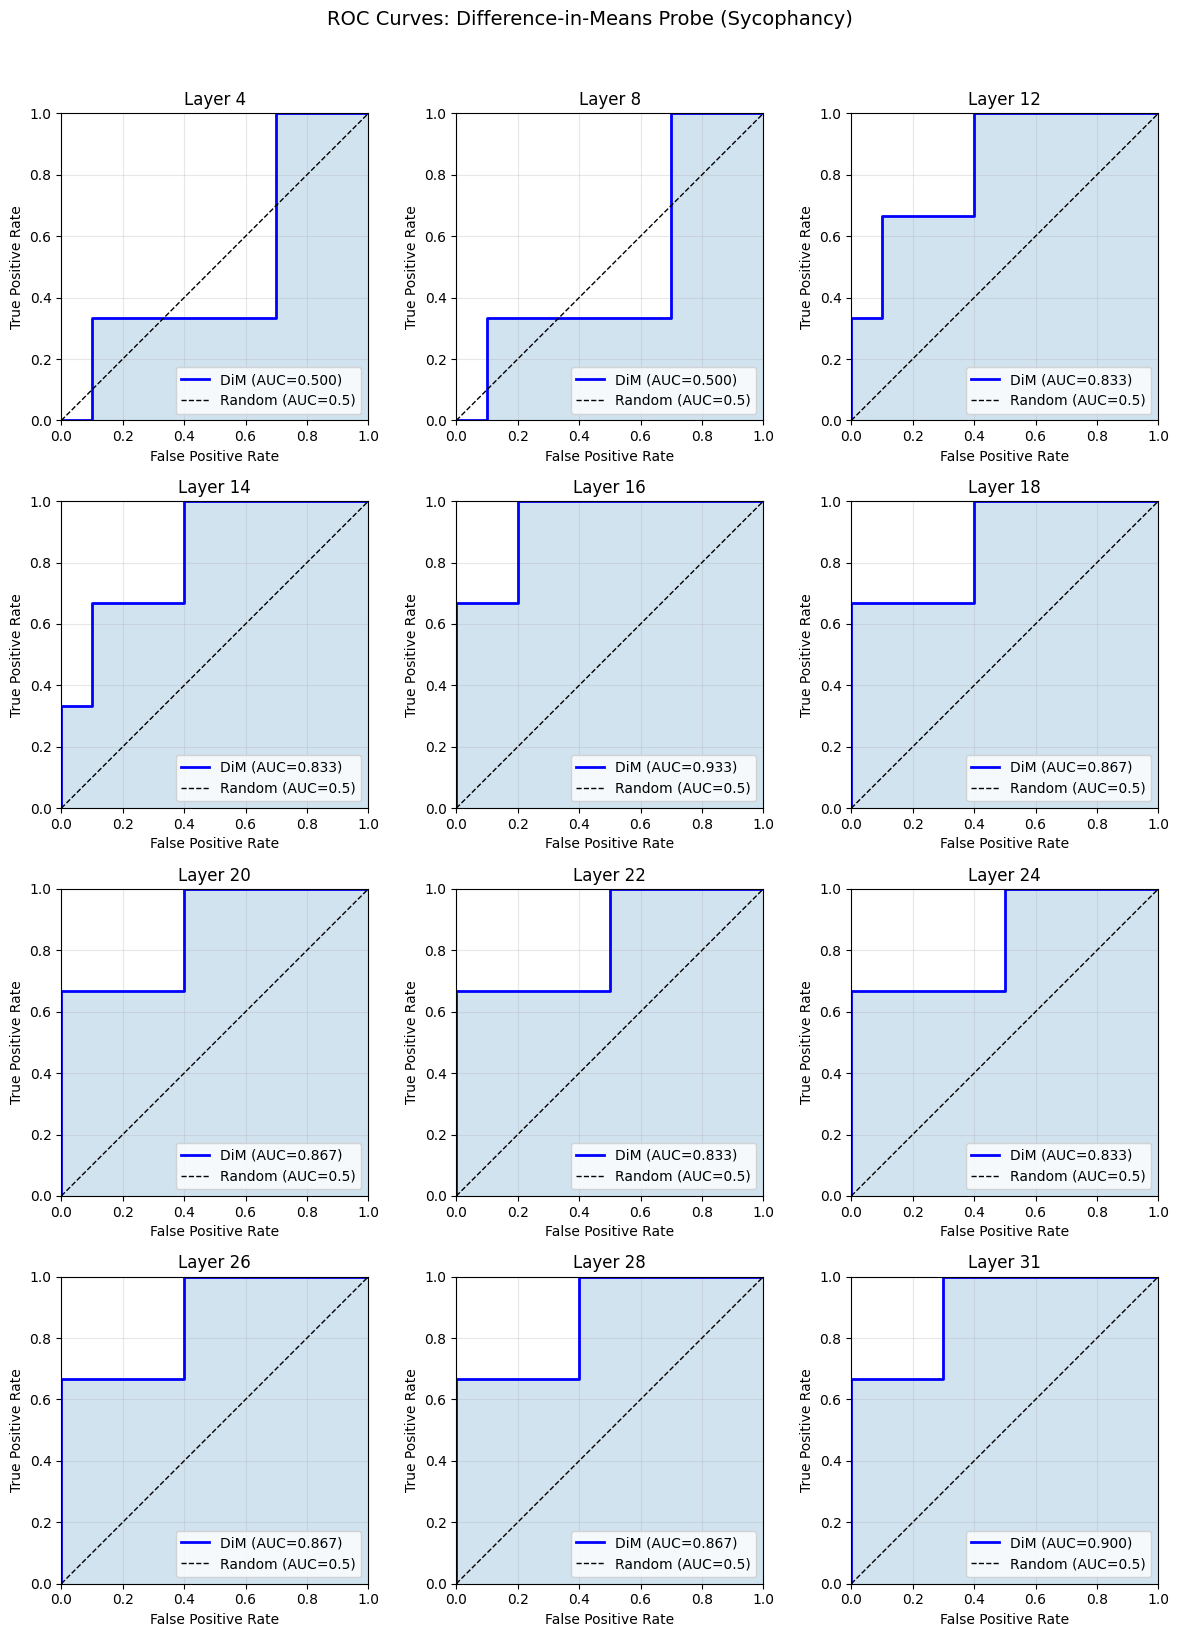

In [10]:
# Cell 8: Plot ROC curves for all layers

n_layers = len(data['layers'])
n_cols = min(3, n_layers)
n_rows = (n_layers + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten() if n_layers > 1 else [axes]

for ax, layer in zip(axes, data['layers']):
    scores = dim_scores_test[layer]
    fpr, tpr, thresholds = roc_curve(test_labels, scores)
    auc = dim_aucs[layer]
    
    ax.plot(fpr, tpr, 'b-', linewidth=2, label=f'DiM (AUC={auc:.3f})')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC=0.5)')
    ax.fill_between(fpr, tpr, alpha=0.2)
    
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Layer {layer}')
    ax.legend(loc='lower right')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

# Hide empty subplots
for ax in axes[len(data['layers']):]:
    ax.axis('off')

plt.suptitle('ROC Curves: Difference-in-Means Probe (Sycophancy)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Logistic Regression Probe

Logistic regression learns the optimal separating direction with L2 regularization to prevent overfitting on high-dimensional data.

In [ ]:
# Cell 9: Train logistic regression probe for each layer

# Use strong regularization (C=0.1) to prevent overfitting
C_VALUE = 0.1

lr_probes = {}  # layer -> trained LogisticRegression model
lr_aucs = {}    # layer -> ROC-AUC on test set

print(f"Training Logistic Regression probes (C={C_VALUE})...\n")

for layer in data['layers']:
    # Get activations
    acts = data['activations'][layer].numpy()
    train_acts = acts[train_indices]
    test_acts = acts[test_indices]
    
    # Train logistic regression
    # Note: l1_ratio=0 is equivalent to penalty='l2' (pure L2 regularization)
    lr = LogisticRegression(
        C=C_VALUE,
        l1_ratio=0,
        solver='lbfgs',
        max_iter=1000,
        random_state=42,
    )
    lr.fit(train_acts, train_labels)
    lr_probes[layer] = lr
    
    # Predict probabilities on test set
    test_probs = lr.predict_proba(test_acts)[:, 1]  # P(sycophantic)
    
    # Compute ROC-AUC
    auc = roc_auc_score(test_labels, test_probs)
    lr_aucs[layer] = auc
    
    # Compare DiM direction with LR weights
    dim_dir = dim_directions[layer]
    lr_dir = lr.coef_[0] / np.linalg.norm(lr.coef_[0])
    cosine_sim = np.dot(dim_dir, lr_dir)
    
    print(f"Layer {layer}:")
    print(f"  LR ROC-AUC: {auc:.4f} (DiM was {dim_aucs[layer]:.4f})")
    print(f"  Cosine similarity (DiM vs LR direction): {cosine_sim:.4f}")
    print()

print("=" * 50)
best_layer_lr = max(lr_aucs, key=lr_aucs.get)
print(f"Best layer (LR): {best_layer_lr} (AUC = {lr_aucs[best_layer_lr]:.4f})")

Training Logistic Regression probes (C=0.1)...

Layer 4:
  LR ROC-AUC: 0.5000 (DiM was 0.5000)
  Cosine similarity (DiM vs LR direction): 1.0000

Layer 8:
  LR ROC-AUC: 0.5000 (DiM was 0.5000)
  Cosine similarity (DiM vs LR direction): 0.9992

Layer 12:
  LR ROC-AUC: 0.9000 (DiM was 0.8333)
  Cosine similarity (DiM vs LR direction): 0.9981

Layer 14:
  LR ROC-AUC: 0.9000 (DiM was 0.8333)
  Cosine similarity (DiM vs LR direction): 0.9958

Layer 16:
  LR ROC-AUC: 0.9333 (DiM was 0.9333)
  Cosine similarity (DiM vs LR direction): 0.9922

Layer 18:
  LR ROC-AUC: 0.8667 (DiM was 0.8667)
  Cosine similarity (DiM vs LR direction): 0.9807

Layer 20:
  LR ROC-AUC: 0.8667 (DiM was 0.8667)
  Cosine similarity (DiM vs LR direction): 0.9732

Layer 22:
  LR ROC-AUC: 0.8333 (DiM was 0.8333)
  Cosine similarity (DiM vs LR direction): 0.9618

Layer 24:
  LR ROC-AUC: 0.8333 (DiM was 0.8333)
  Cosine similarity (DiM vs LR direction): 0.9485



/Users/amiyadiwan/Desktop/MATS_Neel/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/amiyadiwan/Desktop/MATS_Neel/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/amiyadiwan/Desktop/MATS_Neel/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated

Layer 26:
  LR ROC-AUC: 0.8333 (DiM was 0.8667)
  Cosine similarity (DiM vs LR direction): 0.9262

Layer 28:
  LR ROC-AUC: 0.8667 (DiM was 0.8667)
  Cosine similarity (DiM vs LR direction): 0.9030

Layer 31:
  LR ROC-AUC: 0.9000 (DiM was 0.9000)
  Cosine similarity (DiM vs LR direction): 0.8431

Best layer (LR): 16 (AUC = 0.9333)


/Users/amiyadiwan/Desktop/MATS_Neel/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/amiyadiwan/Desktop/MATS_Neel/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


In [12]:
# Cell 10: Compare DiM vs Logistic Regression

print("Comparison: Difference-in-Means vs Logistic Regression")
print("=" * 60)
print(f"{'Layer':<10} {'DiM AUC':<12} {'LR AUC':<12} {'Improvement':<12}")
print("-" * 60)

for layer in data['layers']:
    dim_auc = dim_aucs[layer]
    lr_auc = lr_aucs[layer]
    improvement = lr_auc - dim_auc
    
    print(f"{layer:<10} {dim_auc:<12.4f} {lr_auc:<12.4f} {improvement:+.4f}")

print()

# Overall best
best_dim = max(dim_aucs.values())
best_lr = max(lr_aucs.values())
best_overall = max(best_dim, best_lr)

print(f"Best DiM AUC: {best_dim:.4f}")
print(f"Best LR AUC: {best_lr:.4f}")
print()

# Success criteria
if best_overall >= 0.7:
    print(f"SUCCESS: Best AUC = {best_overall:.4f} >= 0.7 threshold")
    print("Proceed to steering experiment (Notebook 09)")
else:
    print(f"BELOW THRESHOLD: Best AUC = {best_overall:.4f} < 0.7")
    print("Consider:")
    print("  - Different token position")
    print("  - More data")
    print("  - Document as informative negative result")

Comparison: Difference-in-Means vs Logistic Regression
Layer      DiM AUC      LR AUC       Improvement 
------------------------------------------------------------
4          0.5000       0.5000       +0.0000
8          0.5000       0.5000       +0.0000
12         0.8333       0.9000       +0.0667
14         0.8333       0.9000       +0.0667
16         0.9333       0.9333       +0.0000
18         0.8667       0.8667       +0.0000
20         0.8667       0.8667       +0.0000
22         0.8333       0.8333       +0.0000
24         0.8333       0.8333       +0.0000
26         0.8667       0.8333       -0.0333
28         0.8667       0.8667       -0.0000
31         0.9000       0.9000       +0.0000

Best DiM AUC: 0.9333
Best LR AUC: 0.9333

SUCCESS: Best AUC = 0.9333 >= 0.7 threshold
Proceed to steering experiment (Notebook 09)


## PCA Visualization

Project high-dimensional activations to 2D for visualization.

Visualizing layer 16 (best DiM AUC = 0.9333)

Variance explained by PC1: 27.9%
Variance explained by PC2: 13.7%
Total variance explained: 41.6%


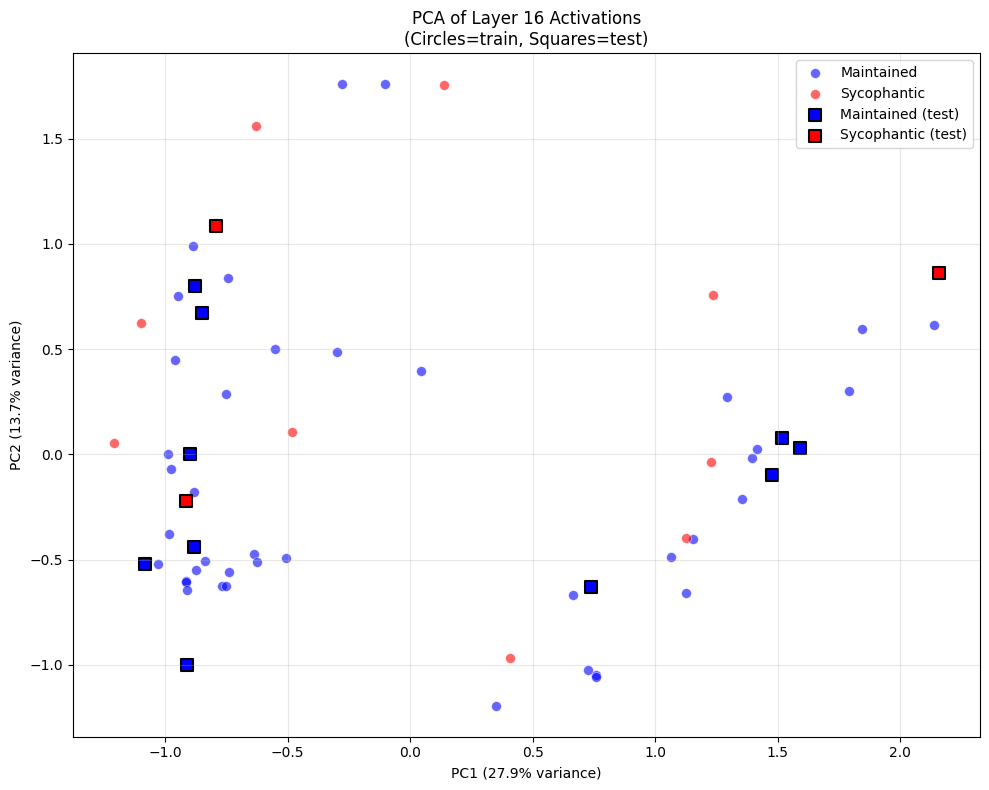

In [13]:
# Cell 11: PCA visualization for best layer

# Use the layer with best DiM AUC
viz_layer = best_layer_dim
print(f"Visualizing layer {viz_layer} (best DiM AUC = {dim_aucs[viz_layer]:.4f})\n")

# Get all activations for this layer
acts = data['activations'][viz_layer].numpy()

# Fit PCA on all data
pca = PCA(n_components=2, random_state=42)
acts_2d = pca.fit_transform(acts)

print(f"Variance explained by PC1: {pca.explained_variance_ratio_[0]*100:.1f}%")
print(f"Variance explained by PC2: {pca.explained_variance_ratio_[1]*100:.1f}%")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum()*100:.1f}%")

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Separate by label
sycophantic_mask = labels == 1
maintained_mask = labels == 0

ax.scatter(
    acts_2d[maintained_mask, 0], acts_2d[maintained_mask, 1],
    c='blue', alpha=0.6, label='Maintained', s=50, edgecolors='white', linewidth=0.5
)
ax.scatter(
    acts_2d[sycophantic_mask, 0], acts_2d[sycophantic_mask, 1],
    c='red', alpha=0.6, label='Sycophantic', s=50, edgecolors='white', linewidth=0.5
)

# Mark test set with different markers
test_mask = np.zeros(len(labels), dtype=bool)
test_mask[test_indices] = True

ax.scatter(
    acts_2d[test_mask & maintained_mask, 0], acts_2d[test_mask & maintained_mask, 1],
    c='blue', marker='s', s=80, edgecolors='black', linewidth=1.5, label='Maintained (test)'
)
ax.scatter(
    acts_2d[test_mask & sycophantic_mask, 0], acts_2d[test_mask & sycophantic_mask, 1],
    c='red', marker='s', s=80, edgecolors='black', linewidth=1.5, label='Sycophantic (test)'
)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
ax.set_title(f'PCA of Layer {viz_layer} Activations\n(Circles=train, Squares=test)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

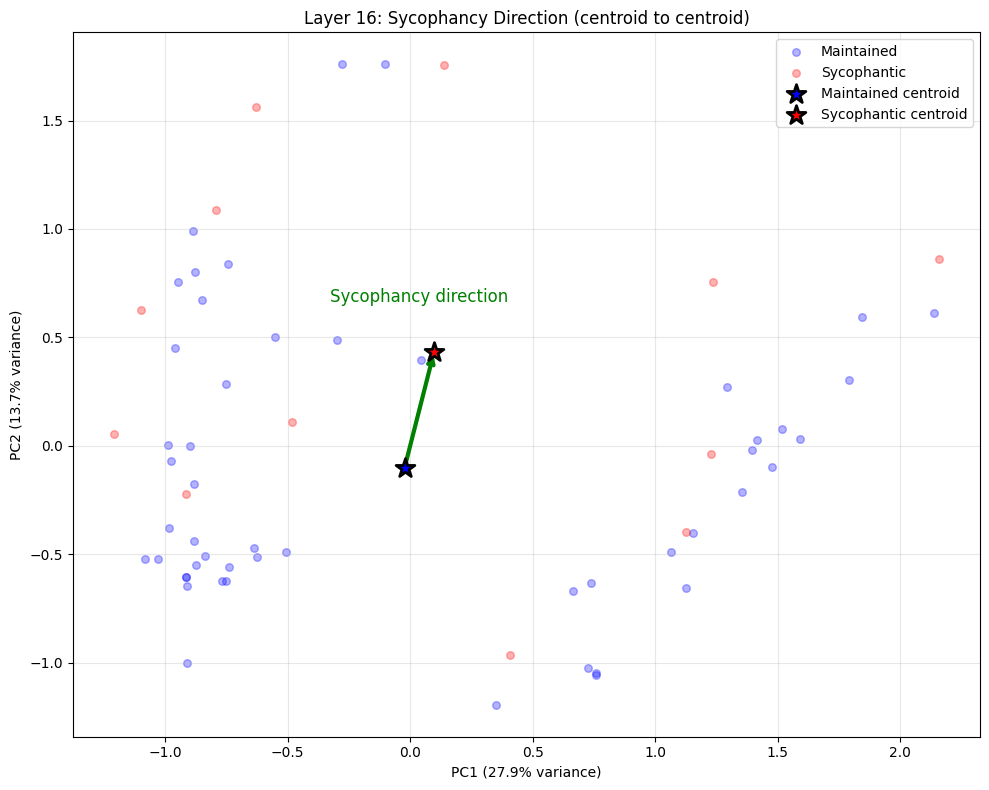

In [14]:
# Cell 12: Visualize DiM direction in PCA space

# Get class centroids
mean_maintained = acts[maintained_mask].mean(axis=0)
mean_sycophantic = acts[sycophantic_mask].mean(axis=0)
mean_maintained_2d = pca.transform(mean_maintained.reshape(1, -1))[0]
mean_sycophantic_2d = pca.transform(mean_sycophantic.reshape(1, -1))[0]

fig, ax = plt.subplots(figsize=(10, 8))

# Plot data points (faded)
ax.scatter(
    acts_2d[maintained_mask, 0], acts_2d[maintained_mask, 1],
    c='blue', alpha=0.3, s=30, label='Maintained'
)
ax.scatter(
    acts_2d[sycophantic_mask, 0], acts_2d[sycophantic_mask, 1],
    c='red', alpha=0.3, s=30, label='Sycophantic'
)

# Plot centroids
ax.scatter(
    mean_maintained_2d[0], mean_maintained_2d[1],
    c='blue', s=200, marker='*', edgecolors='black', linewidth=2,
    label='Maintained centroid', zorder=5
)
ax.scatter(
    mean_sycophantic_2d[0], mean_sycophantic_2d[1],
    c='red', s=200, marker='*', edgecolors='black', linewidth=2,
    label='Sycophantic centroid', zorder=5
)

# Draw arrow for DiM direction (from maintained to sycophantic centroid)
ax.annotate(
    '', xy=mean_sycophantic_2d, xytext=mean_maintained_2d,
    arrowprops=dict(arrowstyle='->', color='green', lw=3),
)
ax.text(
    (mean_maintained_2d[0] + mean_sycophantic_2d[0]) / 2,
    (mean_maintained_2d[1] + mean_sycophantic_2d[1]) / 2 + 0.5,
    'Sycophancy direction', fontsize=12, color='green', ha='center'
)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
ax.set_title(f'Layer {viz_layer}: Sycophancy Direction (centroid to centroid)')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Save Probes

In [15]:
# Cell 13: Save probes
probes_dir = RUN_DIR / "probes"
probes_dir.mkdir(exist_ok=True)

save_path = probes_dir / "sycophancy_probes.pt"

save_data = {
    "model_name": data['model_name'],
    "layers": data['layers'],
    "token_position": data.get('token_position', 'unknown'),
    "dim_directions": dim_directions,
    "dim_aucs": dim_aucs,
    "lr_weights": {layer: lr_probes[layer].coef_[0] for layer in data['layers']},
    "lr_biases": {layer: lr_probes[layer].intercept_[0] for layer in data['layers']},
    "lr_aucs": lr_aucs,
    "best_layer_dim": best_layer_dim,
    "best_layer_lr": best_layer_lr,
    "train_indices": train_indices,
    "test_indices": test_indices,
    "n_train": len(train_indices),
    "n_test": len(test_indices),
    "training_timestamp": datetime.now().isoformat(),
}

torch.save(save_data, save_path)
print(f"Saved probes to: {save_path}")

Saved probes to: experiments/run_20251229_051428_sycophancy/probes/sycophancy_probes.pt


In [16]:
# Cell 14: Validation - load and verify

loaded = torch.load(save_path)

print("Validation - loaded probe data:")
print(f"  Model: {loaded['model_name']}")
print(f"  Layers: {loaded['layers']}")
print(f"  Best layer (DiM): {loaded['best_layer_dim']} (AUC={loaded['dim_aucs'][loaded['best_layer_dim']]:.4f})")
print(f"  Best layer (LR): {loaded['best_layer_lr']} (AUC={loaded['lr_aucs'][loaded['best_layer_lr']]:.4f})")
print(f"  Train/test split: {loaded['n_train']}/{loaded['n_test']}")
print(f"\nDiM direction shapes:")
for layer, direction in loaded['dim_directions'].items():
    print(f"  Layer {layer}: {direction.shape}")

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.core.multiarray._reconstruct was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy.core.multiarray._reconstruct])` or the `torch.serialization.safe_globals([numpy.core.multiarray._reconstruct])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

## Summary

Probe training complete! Results saved to:
```
experiments/run_XXXXXX_sycophancy/probes/sycophancy_probes.pt
```

**Contents:**
- `dim_directions`: DiM direction vectors (unit normalized) per layer
- `dim_aucs`: ROC-AUC scores for DiM method
- `lr_weights`, `lr_biases`: Logistic regression probe weights
- `lr_aucs`: ROC-AUC scores for LR method

**Next steps (Notebook 09: Steering):**
1. Load the sycophancy direction from best layer
2. Apply directional ablation during generation
3. Test if ablation reduces sycophancy rate
4. Report primary (held-out) and secondary (all samples) metrics

In [ ]:
# Cell 15: Print paths for next notebook
print(f"\nFor notebook 09, use:")
print(f'RUN_DIR = Path("{RUN_DIR}")')
print(f'PROBES_PATH = RUN_DIR / "probes/sycophancy_probes.pt"')

In [ ]:
# Cell 16: Save plot
plots_dir = RUN_DIR / "plots"
plots_dir.mkdir(exist_ok=True)

# Re-create and save the PCA plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(acts_2d[maintained_mask, 0], acts_2d[maintained_mask, 1],
           c='blue', alpha=0.6, label='Maintained', s=50)
ax.scatter(acts_2d[sycophantic_mask, 0], acts_2d[sycophantic_mask, 1],
           c='red', alpha=0.6, label='Sycophantic', s=50)
ax.scatter(mean_maintained_2d[0], mean_maintained_2d[1],
           c='blue', s=200, marker='*', edgecolors='black', linewidth=2, label='Maintained centroid')
ax.scatter(mean_sycophantic_2d[0], mean_sycophantic_2d[1],
           c='red', s=200, marker='*', edgecolors='black', linewidth=2, label='Sycophantic centroid')
ax.annotate('', xy=mean_sycophantic_2d, xytext=mean_maintained_2d,
            arrowprops=dict(arrowstyle='->', color='green', lw=3))
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
ax.set_title(f'Sycophancy Direction - Layer {viz_layer} (AUC={dim_aucs[viz_layer]:.3f})')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(plots_dir / "sycophancy_pca.png", dpi=150)
print(f"Saved plot to: {plots_dir / 'sycophancy_pca.png'}")
plt.close()

In [ ]:
# Cell 17: (Optional) Push to GitHub
# Uncomment to save probes to repo

# !git add experiments/
# !git commit -m "Add sycophancy probes from notebook 08"
# !git push